In [17]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import pandas as pd
import itertools 
from matplotlib.backends.backend_pdf import PdfPages
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq

In [18]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [19]:
def read_cs_md(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[] 
        timeseries=np.asarray(riga[2:]).astype(float)
        confd[key2][key]=timeseries
 return(confd)

def read_exp_cs(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[]
        confd[key2][key] += map(float, [float(riga[2])])
 return(confd)

def add_md_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        key2=riga[0]
        timeseries=np.asarray(riga[1:]).astype(float)
        dict[key][key2]=[]
        dict[key][key2]=(timeseries)
  return(dict)

def add_exp_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        key2=riga[0]
        dict[key][key2]=[]
        dict[key][key2] += map(float, [float(riga[1])])
  return(dict)

def add_md_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[1:]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)

def scale_rdc_Q_fit(exp,calc):
     def residuals(p,y,x):
         c = p
         err = ((c*y)-x)
         return err
     p0=0.0001
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c,d=leastsq(residuals,p0,args=(calc,exp))
     fit=c*calc
     #print("Calc:",calc,"Fit:",fit)
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit
    
def scale_rdc_Q(exp,calc):
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c=np.linalg.norm(np.dot(exp,calc))/(np.dot(calc,calc))
     fit=c*calc
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit,c

In [20]:
outdir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/c22star-TIP3P/reweight/'
datadir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/c22star-TIP3P/Average_Data/'
expdatadir = '/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/Exp_Data/'

if not os.path.exists(outdir):
    os.makedirs(outdir)

print("outdir",outdir)
print("datadir",datadir)
print("expdata_dir",expdatadir)

outdir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/c22star-TIP3P/reweight/
datadir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/c22star-TIP3P/Average_Data/
expdata_dir /Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/Exp_Data/


In [21]:
expdata=read_exp_cs(expdatadir+'/CS.exp.dat')
compdata=read_cs_md(datadir+'/chemical_shifts.all.csv')

expdata=add_exp_scalar(1.24,expdata,'Rg')
compdata=add_md_scalar(datadir+'/Rgyr-CA.all.csv',compdata,'Rg')

expdata=add_exp_data(expdatadir+'/RDC.exp.dat',expdata,'RDC')
compdata=add_md_data(datadir+'/RDC.all.csv',compdata,'RDC')

expdata=add_exp_data(expdatadir+'/JHNHA.exp.dat',expdata,'JHNHA')
compdata=add_md_data(datadir+'/J_HNHA0.all.csv',compdata,'JHNHA')

reweight_data_frames=len(compdata['Rg'][0])
print("Reweight Data Frames:",reweight_data_frames)

Reweight Data Frames: 29977


In [22]:
#Set Data For Reweighting and Validation
Reweight_Data=['CA','CB','H','RDC', 'JHNHA', 'Rg']
#Reweight_Data=['CA','CB','H','N','HA','Rg']
Validation_Data=['CA','Rg','CB','H','RDC']
#STRENGTH OF THE RESTRAINT
#Max+Francesco's Theta
sigma_m=float(100.0)

#Validation_Data=['HA','CA','CB','H','N']
#Reweight_Data=['RDC','JHNHA']
compare=[]
exp_r=[] 
traj_r=[]
err_r=[]
data_r_t=[]
data_r_type={}

traj_v=[]
exp_v=[]
data_v_t=[]
data_v_type={}
err_v=[]

#PREFACTORS FOR ERROR ESTIMATES FOR EACH EXPERIMENTAL DATA
#Prefactors Sigma
err_d = { 'HA': 0.1,
          'CA': 0.2,
          'CB': 0.2,
          'C':  0.2,
          'H':  0.1,
          'HA2': 0.1,
          'HA3': 0.1,
          'N': 0.5 ,
          'RDC': 0.5 ,
          'Rg': 0.001,
          'PRE_2': 0.1,
          'PRE_59': 0.1,
          'SAXS': 0.003,
          'JHNHA': 0.25}

#For Debugging 
compare_dict_r = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { },
          'RDC': {},
          'Rg' : {}, 
          'PRE_2' : {}, 
          'PRE_59' : {},
          'SAXS' : {},
          'JHNHA': {}}

#Also For Debugging 
compare_dict_v = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { },
          'RDC': {},
          'JHNHA': {},
          'PRE_2' : {}, 
          'PRE_59' : {},
          'SAXS' : {},        
          'Rg' : {}}

#Process Reweight data into arrays
for key in Reweight_Data:   
 for key2 in expdata[key]:
  #print(key,key2,expdata[key][key2][0])
  #Check if Experimental Value is 0, if not retrieve the MD timeseries 
  if expdata[key][key2][0]!=0:  
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
     compare_dict_r[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_r.append(compdata[key][key2])
     exp_r.append(expdata[key][key2][0])
     err_r.append(err_d[key]) 
     data_r_t.append(str(key))

for key in Reweight_Data: 
   data_id=np.zeros(len(data_r_t)) 
   for i, id in enumerate(data_r_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_r_type[key]=data_id 

#Process Validation data into arrays
for key in Validation_Data:   
 for key2 in expdata[key]:
  if expdata[key][key2][0]!=0:
   if key2 in compdata[key]:
    if compdata[key][key2][0]!=0:
    #This is a hack so it doesn't choke for non-residue specific data read in as an array
    #if np.average(compdata[key][key2][0])!=0:
     compare_dict_v[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
     traj_v.append(compdata[key][key2])
     exp_v.append(expdata[key][key2][0])
     err_v.append(err_d[key]) 
     data_v_t.append(str(key))

for key in Validation_Data: 
   data_id=np.zeros(len(data_v_t)) 
   for i, id in enumerate(data_v_t): 
     if id==str(key):
      data_id[i]=float(1)
   data_v_type[key]=data_id 

In [23]:
traj_r=np.asarray(traj_r)
traj_v=np.asarray(traj_v)
# experimental data for reweighting - 1 column per exp data - 1 row
obs_exp_r=np.asarray(exp_r)
obs_exp_v=np.asarray(exp_v)
# predictor/experimental errors for reweighting - 1 column per exp data - 1 row
err_r=np.asarray(err_r)
err_v=np.asarray(err_v)

#Uniform Initial Weights For Each Frame
weight_bias=np.ones(len(traj_r[0]))
#sigma_m=float(0.1)
# calculate sigma vector
sigma=sigma_m*err_r
#print(sigma)
#number of observables
nobs_r=len(sigma)
nobs_v=len(obs_exp_v)
#number of frames
nframes=len(traj_r[0])

print('# of Frames:',nframes)
#log.write('# of Frames:%s'%nframes+"\n")

print('Reweight Data Points:',nobs_r)
#log.write('Reweight Data Points: %s'%nobs_r+"\n")

for key in data_r_type:
    print(str(key)+':',sum(data_r_type[key]))
    #log.write(str(key)+': %s'%sum(data_r_type[key])+"\n")
    
print('Validation Data Points:',nobs_v)
#log.write('Validation Data Points: %s'%nobs_v+"\n")
for key in data_v_type:
    print(str(key)+':',sum(data_v_type[key]))

# of Frames: 29977
Reweight Data Points: 169
CA: 38.0
CB: 32.0
H: 37.0
RDC: 25.0
JHNHA: 36.0
Rg: 1.0
Validation Data Points: 133
CA: 38.0
Rg: 1.0
CB: 32.0
H: 37.0
RDC: 25.0


In [24]:
#Determine optimally scaling for calculated RDCs
if 'RDC' in Reweight_Data:    
 initial_weights=weight_bias
 initial_weights/=np.sum(initial_weights)
 initial_obs_r=np.dot(traj_r,initial_weights)
 initial_obs_r
 exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
 calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
 qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
 qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
    
 if(qf_neg<qf_pos):
    c=-c_neg
 else: 
    c=c_pos
    
 RDC_rows=np.where(data_r_type['RDC']==1)
 traj_r[RDC_rows]=traj_r[RDC_rows]*c


if 'RDC' in Validation_Data:    
 initial_weights=weight_bias
 initial_weights/=np.sum(initial_weights)
 initial_obs_v=np.dot(traj_v,initial_weights)
 exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
 calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
 qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
 qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)

 if(qf_neg<qf_pos):
    c=-c_neg
 else: 
    c=c_pos
    
 RDC_rows=np.where(data_v_type['RDC']==1)
 traj_v[RDC_rows]=traj_v[RDC_rows]*c

In [25]:
# maxent calculation

# function to be minimized:
# attention: it reads global variables weight_bias, obs_exp, and sigma
def func(l):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights

    # same stuff with original ensemble
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    # regularization term
    # REGULARIZE
    f += 0.5*np.sum(sigma*l**2)
    der += sigma*l

    return(f,der)

In [26]:
# perform minimization
#res.X lagrange multiplier
#res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)

# various initial RMSE
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q scaled:", end = '')
      print(" %6.3lf" % qf)

print("Initial RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end= '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

print("Final RMSE validation data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

for t in data_v_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_v*data_v_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      print(" *    RDC Q:", end = '')
      print(" %6.3lf" % qi)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

    
# Kish effective size
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
print("Kish ratio : %9.6lf" % (Ks_a/Ks_b*100.0))

np.savetxt('%s/weights_final.dat'%(outdir),final_weights,fmt=" %6.12lf")
# print final weights to file
f=open("%s/weights_final.a.dat"%outdir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

Initial RMSE reweight data 
 * Total :      0.922
 *    CA :      0.444
 *    CB :      0.414
 *     H :      0.292
 *    RDC :      2.102
 *    RDC Q:  0.661
 *    RDC Q scaled:  0.661
 *    JHNHA :      0.688
 *    Rg :      0.027
Initial RMSE validation data
 * Total :      0.976
 *    CA :      0.444
 *    Rg :      0.027
 *    CB :      0.414
 *     H :      0.292
 *    RDC :      2.102
 *    RDC Q:  0.661
 *    RDC Q_scaled:  0.661
minimization worked: True
Final RMSE reweight data
 * Total :      0.541
 *    CA :      0.357
 *    CB :      0.354
 *     H :      0.268
 *    RDC :      1.004
 *    RDC Q:  0.316
 *    RDC Q_scaled:  0.307
 *    JHNHA :      0.593
 *    Rg :      0.017
Final RMSE validation data
 * Total :      0.526
 *    CA :      0.357
 *    Rg :      0.017
 *    CB :      0.354
 *     H :      0.268
 *    RDC :      1.004
 *    RDC Q:  0.316
 *    RDC Q_scaled:  0.307
Initial Kish size :  1.000000 29977
Reweighted Kish size :  0.524121 15711
Kish ratio : 52.4120

In [27]:
pp = PdfPages("%s/reweight.pdf"%outdir)

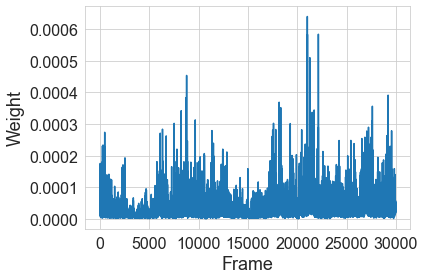

In [28]:
plt.plot(final_weights)
plt.ylabel('Weight',size=18)
plt.xlabel('Frame',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.tight_layout()
plt.savefig('%s/FrameWeights.png'%outdir)
pp.savefig()
plt.show()

Rg Exp:  1.24+_  0.14 Rg Initial:  1.21 Rg Reweight:  1.26 


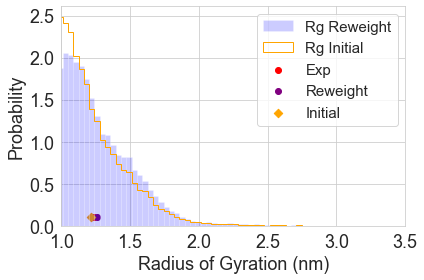

In [29]:
rg_i=np.dot(compare_dict_v['Rg'][0][1],initial_weights)
rg_r=np.dot(compare_dict_v['Rg'][0][1],final_weights)
rg_exp=expdata['Rg'][0][0]
rg_err=.14
print("Rg Exp:%6.2lf+_%6.2lf"%(rg_exp,rg_err),"Rg Initial:%6.2lf"%rg_i,"Rg Reweight:%6.2lf "%rg_r)

plt.hist(compare_dict_v['Rg'][0][1],bins=50,weights=final_weights,density='true',alpha=0.2,label='Rg Reweight',color='blue')
plt.hist(compare_dict_v['Rg'][0][1],bins=50,density='true',color='orange',histtype='step',label='Rg Initial')

plt.scatter(rg_exp,0.1,color='red',label='Exp')
plt.scatter(rg_r,0.1,color='purple',label='Reweight')
plt.scatter(rg_i,0.1,color='orange',marker='D',label='Initial')
plt.ylabel('Probability',size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='18')
plt.yticks(size='18')
plt.xlabel('Radius of Gyration (nm)',size=18)
plt.legend(loc='upper right',fontsize=15)
plt.xlim(1.0, 3.5)

plt.tight_layout()
plt.savefig('%s/Rg.reweight.png'%outdir)
pp.savefig()
plt.show()
plt.clf()
plt.close()

In [30]:
name=[]
before=[]
after=[]

for t in data_r_type:
    name.append(t)
    if str(t)=='RDC': 
     exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
     calc_rdc_i=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
     calc_rdc_f=np.trim_zeros(final_obs_r*data_r_type['RDC'])    
     qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc_i)
     rmse_before=np.sqrt(qf)
     qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc_f)
     rmse_after=np.sqrt(qf)
    else:
     rmse_before=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
     rmse_after=np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
    before.append(rmse_before)
    after.append(rmse_after)

name.append("Kish_Size")
before.append(Ks_b*nframes)
after.append(Ks_a*nframes) 

name.append("Rg_value 1.24(exp)")
before.append(rg_i)
after.append(rg_r) 

In [31]:
res = sp.optimize.minimize(func, np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)


# ANALYSIS
# calculate normalized initial weights
initial_weights=weight_bias
initial_weights-=np.max(initial_weights)
initial_weights=np.exp(initial_weights)
initial_weights/=np.sum(initial_weights)
# initial average observables for reweighting and validation
initial_obs_r=np.dot(traj_r,initial_weights)
initial_obs_v=np.dot(traj_v,initial_weights)


for t in data_r_type:
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      name.append("RDC Q_scale")
      before.append(qf)
    

    
print("minimization worked:",res.success)
#print("lagrangian multipliers:",res.x)
# calculate normalized final weights
final_weights=(weight_bias-np.dot(res.x,traj_r))
final_weights-=np.max(final_weights)
final_weights=np.exp(final_weights)
final_weights/=np.sum(final_weights)
# final average observables for reweighting and validation
final_obs_r=np.dot(traj_r,final_weights)
final_obs_v=np.dot(traj_v,final_weights)
# various final RMSE

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
      calc_rdc=np.trim_zeros(final_obs_r*data_r_type['RDC'])
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(exp_rdc,calc_rdc)
      after.append(qf)

minimization worked: True
 *    CA :      0.357
 *    CB :      0.354
 *     H :      0.268
 *    RDC :      1.004
 *    JHNHA :      0.593
 *    Rg :      0.017


In [32]:
out=np.column_stack((name,before,after))
df = pd.DataFrame(out)
df.columns = ["Ab40-data", "before", "after"]
df.head()
df.to_csv("%s/table-100.csv"%outdir, float_format='%.3f')

In [33]:
dataset = pd.read_csv('/Users/kaushikborthakur1211/Desktop/sigma-opt-reweighting/Ab40/c22star-TIP3P/reweight/table-100.csv')

# create function that tries to round input to three decimal places,
# returns input if failure occurs (e.g. if not a float)
def try_cutoff(x):

    try:
        return round(float(x), 3)
    except Exception:
        return x

# loop over each column and apply try_cutoff to each element in each column
for field in dataset.columns:


    dataset[field] = dataset[field].map(try_cutoff)

# write new dataset result to CSV file
dataset.to_csv("%s/table-100new.csv"%outdir, index = False)

CA
RMSD_initial: 0.444 RMSD_final: 0.357


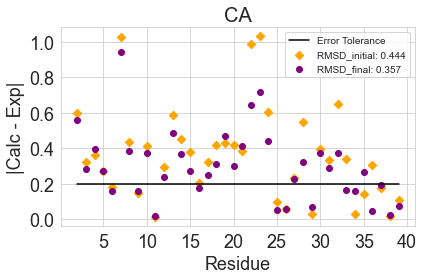

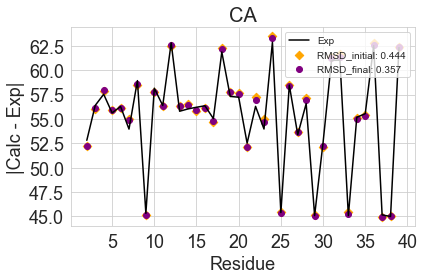

CB
RMSD_initial: 0.414 RMSD_final: 0.354


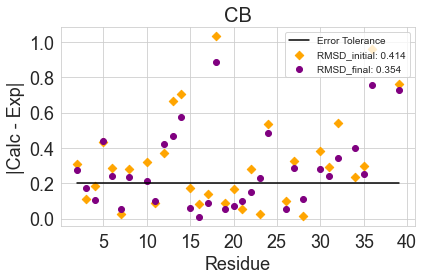

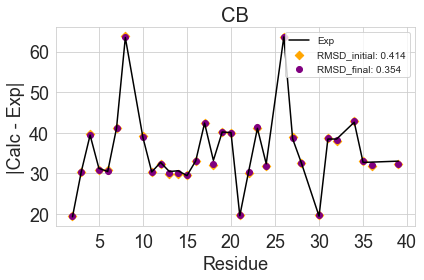

H
RMSD_initial: 0.292 RMSD_final: 0.268


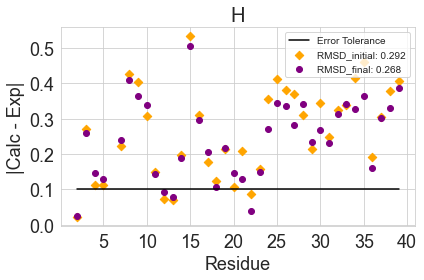

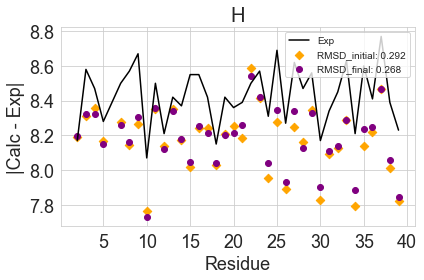

RDC
RMSD_initial: 2.102 RMSD_final: 1.004
RMSD initial scale: 2.102 RMSD final scale: 0.975
Q initial scale: 0.661 Q final scale: 0.307


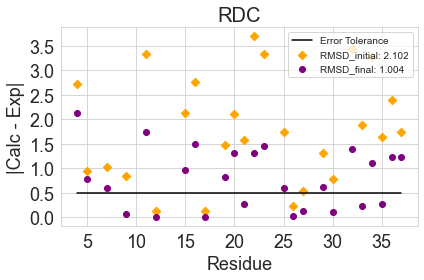

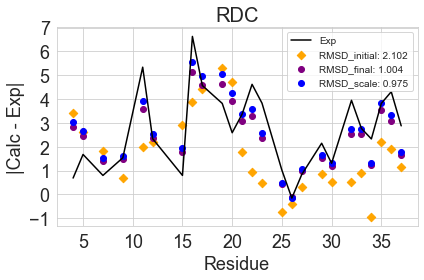

JHNHA
RMSD_initial: 0.688 RMSD_final: 0.593


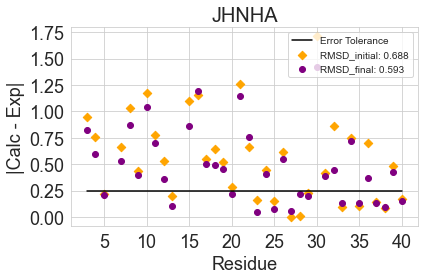

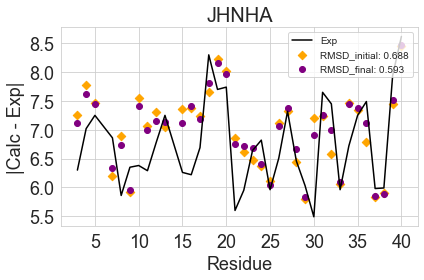

In [34]:
#Plot Fitting Data
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %rmsd_i,"RMSD_final:%6.3lf"%rmsd_f)
  plt.clf()
  if t=='RDC':
   qi_initial,rms_initial,qf_initial,rms_f_initial,rdc_scale_i_initial,c=scale_rdc_Q(exp,initial)
   qi_reweight,rms_i_reweight,qf_reweight,rms_f_reweight,rdc_scale_i_reweight,c=scale_rdc_Q(exp,reweight)
   print("RMSD initial scale:%6.3lf" %rms_f_initial,"RMSD final scale:%6.3lf"%rms_f_reweight)
   print("Q initial scale:%6.3lf" %qf_initial,"Q final scale:%6.3lf"%qf_reweight)
  plt.scatter(np.asarray(resid),np.absolute(initial-exp),color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
  plt.scatter(np.asarray(resid),np.absolute(reweight-exp),color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
  plt.plot(np.asarray(resid),err_fit,color='black',label='Error Tolerance')
  #max_dev=max(np.absolute(initial-exp))
  #plt.ylim(0,max_dev*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout()  
  pp.savefig()
  plt.savefig('%s/%s.reweight.dev.png'%(outdir,t))
  plt.show()
  plt.clf()
  plt.scatter(np.asarray(resid),initial,color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
  plt.scatter(np.asarray(resid),reweight,color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
  if t=='RDC':
   plt.scatter(np.asarray(resid),rdc_scale_i_reweight,color='blue',label="RMSD_scale:%6.3lf"%rms_f_reweight)
  plt.plot(np.asarray(resid),exp,color='black',label='Exp')
  #max_dev=max(np.absolute(initial-exp))
  #plt.ylim(0,max_dev*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  pp.savefig()
  plt.savefig('%s/%s.reweight.png'%(outdir,t))
  plt.show()

CA
RMSD_initial: 0.444 RMSD_final: 0.357


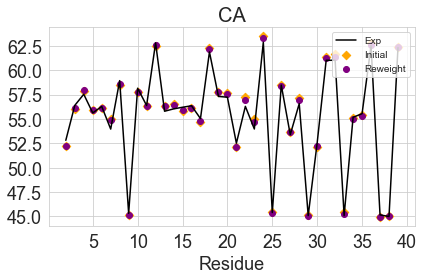

CB
RMSD_initial: 0.414 RMSD_final: 0.354


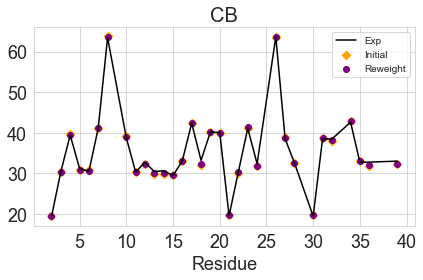

H
RMSD_initial: 0.292 RMSD_final: 0.268


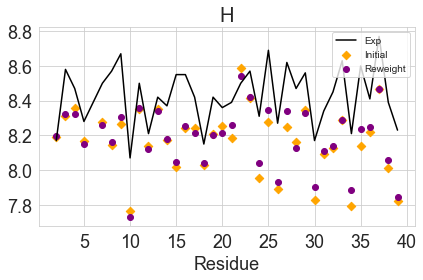

RDC
RMSD_initial: 2.102 RMSD_final: 1.004
Q_inital: 0.6611058246985623 RMS_initial: 2.1019759630892003 Q_reweight: 0.3065627342767615 RMS_reweight: 0.9747115734798877


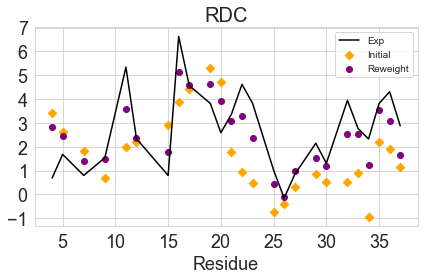

JHNHA
RMSD_initial: 0.688 RMSD_final: 0.593


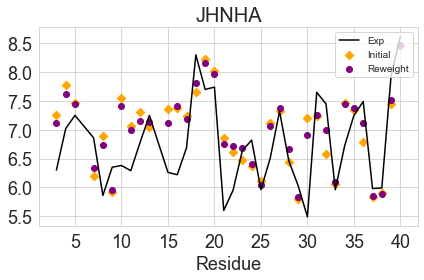

In [35]:
#Plot Fitting Data
for t in Reweight_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_r[t]): 
   resid.append(float(id))
   exp.append(compare_dict_r[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_r*data_r_type[t])
  reweight=np.trim_zeros(final_obs_r*data_r_type[t])
  exp=np.trim_zeros(obs_exp_r*data_r_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
  if t=='RDC':
   qi_i,rms_i_i,qf_i,rms_f_i,i_fit,c=scale_rdc_Q(exp,initial)   
   qi_f,rms_f_f,qf_f,rms_f_f,f_fit,c=scale_rdc_Q(exp,reweight)   
   print("Q_inital:",qf_i,"RMS_initial:",rms_f_i,"Q_reweight:",qf_f,"RMS_reweight:",rms_f_f) 
  plt.clf()
  plt.scatter(np.asarray(resid),initial,color='orange',marker='D',label="Initial")   
  plt.scatter(np.asarray(resid),reweight,color='purple',label="Reweight")
  plt.plot(np.asarray(resid),exp,color='black',label='Exp')

  #max=max(np.absolute(exp))
  #plt.ylim(0,max*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  #plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  pp.savefig()
  plt.savefig('%s/%s.reweight.compare.png'%(outdir,t))
  plt.show()

CA
RMSD_initial: 0.444 RMSD_final: 0.357


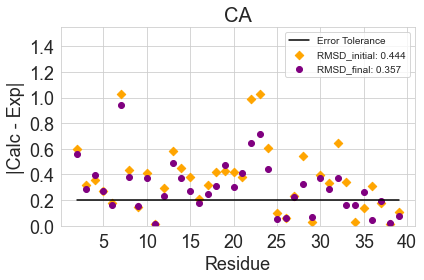

CB
RMSD_initial: 0.414 RMSD_final: 0.354


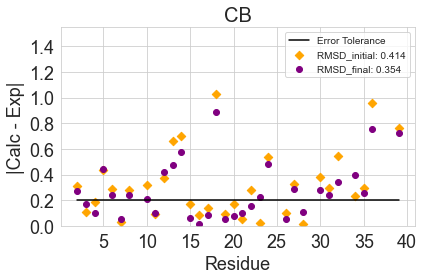

H
RMSD_initial: 0.292 RMSD_final: 0.268


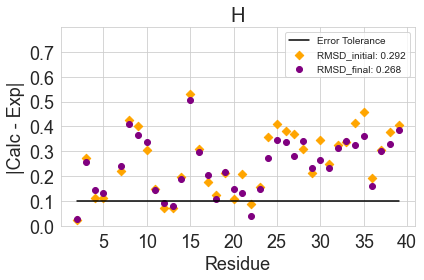

RDC
RMSD_initial: 2.102 RMSD_final: 1.004
Q_inital: 0.6611058246985624 RMS_initial: 2.1019759630892008 Q_reweight: 0.3065627342767616 RMS_reweight: 0.9747115734798879


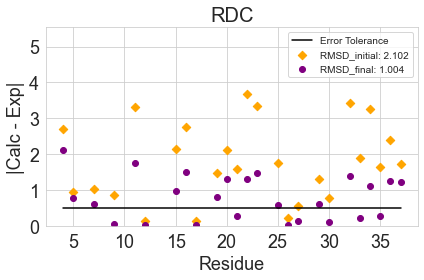

In [36]:
#Plot Validation Data
for t in Validation_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_v[t]): 
   resid.append(float(id))
   exp.append(compare_dict_v[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_v*data_v_type[t])
  reweight=np.trim_zeros(final_obs_v*data_v_type[t])
  exp=np.trim_zeros(obs_exp_v*data_v_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
  if t=='RDC':
   qi_i,rms_i_i,qf_i,rms_f_i,i_fit,c=scale_rdc_Q(exp,initial)   
   qi_f,rms_f_f,qf_f,rms_f_f,f_fit,c=scale_rdc_Q(exp,reweight)   
   print("Q_inital:",qf_i,"RMS_initial:",rms_f_i,"Q_reweight:",qf_f,"RMS_reweight:",rms_f_f)  
  plt.clf()
  plt.scatter(np.asarray(resid),np.absolute(initial-exp),color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
  plt.scatter(np.asarray(resid),np.absolute(reweight-exp),color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
  plt.plot(np.asarray(resid),err_fit,color='black',label='Error Tolerance')
  max_dev=max(np.absolute(initial-exp))
  plt.ylim(0,max_dev*1.5)
  #plt.yticks(np.arange(0,1.8,0.3))
  plt.ylabel('|Calc - Exp|',size=18)
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  pp.savefig()
  plt.savefig('%s/%s.reweight.dev.val.png'%(outdir,t))
  plt.show()

CA
RMSD_initial: 0.444 RMSD_final: 0.357


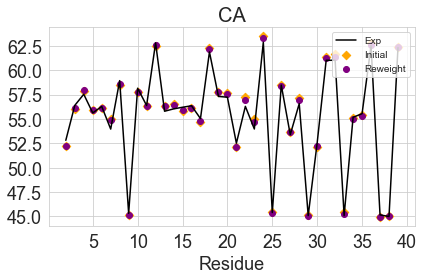

CB
RMSD_initial: 0.414 RMSD_final: 0.354


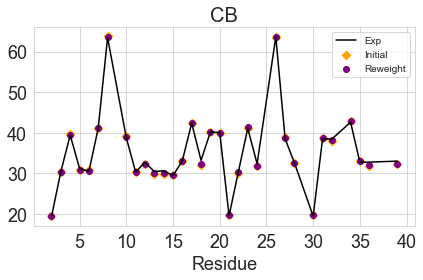

H
RMSD_initial: 0.292 RMSD_final: 0.268


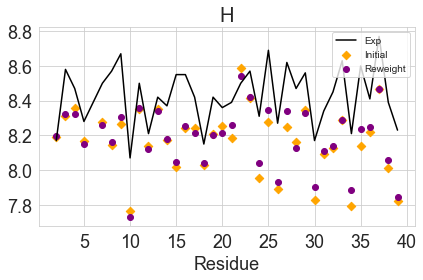

RDC
RMSD_initial: 2.102 RMSD_final: 1.004


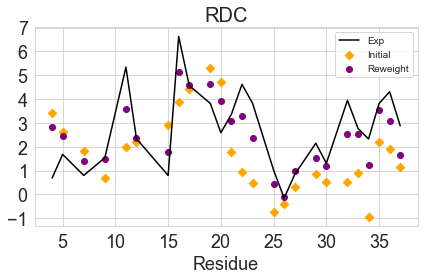

In [37]:
#Plot Validation Data
for t in Validation_Data:
 if t!='Rg':
  print(t)
  resid=[]
  exp=[]
  calc=[]    
  err_fit=[]    
  err=err_d[t]
  for i,id in enumerate(compare_dict_v[t]): 
   resid.append(float(id))
   exp.append(compare_dict_v[t][id][0]) 
   err_fit.append(err)
  initial=np.trim_zeros(initial_obs_v*data_v_type[t])
  reweight=np.trim_zeros(final_obs_v*data_v_type[t])
  exp=np.trim_zeros(obs_exp_v*data_v_type[t])
  err=err_d[t]
  rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
  rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
  print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
  plt.clf()
  plt.scatter(np.asarray(resid),initial,color='orange',marker='D',label="Initial")   
  plt.scatter(np.asarray(resid),reweight,color='purple',label="Reweight")
  plt.plot(np.asarray(resid),exp,color='black',label='Exp')
  plt.title('%s'%t,size='20')
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.xticks(size='18')
  plt.yticks(size='18')
  plt.xlabel('Residue',size=18)
  plt.legend(loc='upper right')
  plt.tight_layout() 
  pp.savefig()
  plt.savefig('%s/%s.reweight.dev.val.png'%(outdir,t))
  plt.show()

In [38]:
pp.close()